# Lab 4: Bayesian optimization of composite functions

In this lab we first show an extended example in which we solve an inverse problem, calibrating a parameter of 

In [1]:
import torch

from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model
from botorch.acquisition.objective import GenericMCObjective
from botorch.models.gp_regression import FixedNoiseGP
from botorch.acquisition.monte_carlo import qExpectedImprovement
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

import math
import numpy as np
import matplotlib.pyplot as plt

# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

# Part 1: Define our optimization problem

Our goal will be to estimate a parameter governing the behavior of a pendulum. We have a physics-based simulator of the pendulum (the function `pendulum` below) that accepts this parameter as input as well as a point in time (in seconds). This simulator can then tell us what the pendulum's height will be at that time.

There is a real value for this parameter, `x_real`, which was used to generate some observations of the pendulum's height. These observations are in the vectors `t_obs`, which indicate when in time the observations were taken, and `y_obs`, which indicate the pendulum's height at these times.

Imagine we don't know `x_real` and want to estimate it by running the simulator at a bunch of different candidate values for this parameter. We define an objective function that takes the predictions for `y_obs` outputted by the simulator, compares them to `y_obs`, and then takes the sum of squared differences. We can estimate `x_real` by finding the value of the parameter `x` that minimizes this sum of squared differences.

This optimization problem is the one that we are going to solve using Bayesian optimization of composite functions.

In [2]:
def pendulum(x, time, constants=[1.0,0.5,2]):
    
    # We want x to be passed as an array, to make it easier to generalize to calibrating multiple parameters
    # If someone passes a scalar, convert it to an array
    if np.isscalar(x):
        x = [x]
            
    # x is the parameter we wish to calibrate, expressed as a vector of length 1
    # x determines the pendulum's period: the period is 2*pi / param
    # constants[0] is the amplitude of the pendulum
    # constants[1] is a phase shift that governs when the pendulum reaches its maximum height 
    # constants[2] is how high the center of the pendulum is off the ground
    return constants[0]*np.cos(constants[1] + x[0]*time)+constants[2]

In [3]:
# This is the correct value of the parameter
x_real = np.pi/3

# We observe the pendulum's height at several points in time
t_obs = [0.1, 2.0, 2.5, 10.0]
y_obs = [pendulum(x_real,t) for t in t_obs]

# Our goal is to estimate some or all of the components of theta_real
# using t_obs, y_obs, and the pendulum function

# Upper and lower bounds for our search
lower = 0.0
upper = 3.0

In [4]:
def predict_obs(x):
    return [pendulum(x,t) for t in t_obs] # vector of predicted values for y

def sum_squared_err(y_pred):
    err = [y_pred[i]-y_obs[i] for i in range(len(y_obs))]
    return np.sum(np.power(err,2))

def objective(x):
    return sum_squared_err(predict_obs(x))

# Part 2: Plots illustrating our optimization problem

Text(0.5, 1.0, "Pendulum's height over time")

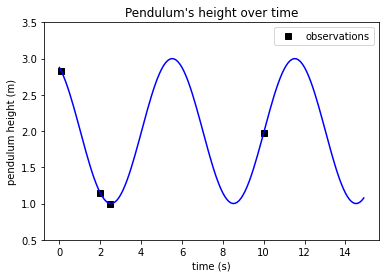

In [5]:
t_plt = np.arange(0,15,.1)
y_plt = [pendulum(x_real,t) for t in t_plt]
plt.plot(t_obs,y_obs,'ks')
plt.plot(t_plt, y_plt,'b-')
plt.xlabel('time (s)')
plt.ylabel('pendulum height (m)')
plt.ylim(0.5,3.5)
plt.legend(['observations'],loc='upper right')
plt.title('Pendulum\'s height over time')

In [6]:
assert objective(x_real) == 0.0

Text(0, 0.5, 'sum of squared error')

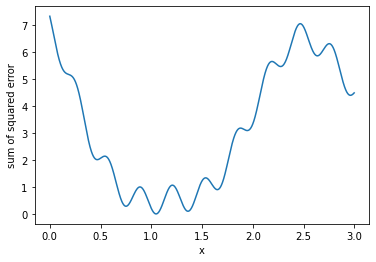

In [7]:
# Make a plot of the sum of squared error objective versus x
x = np.arange(lower,upper,.001)
y = [objective(xi) for xi in x]
plt.plot(x,y)
plt.xlabel('x')
plt.ylabel('sum of squared error')

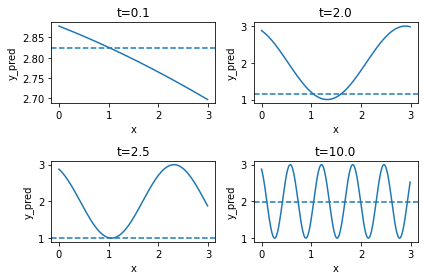

In [8]:
# We plot the prediction from the simulation for each timepoint as a separate graph
# We also plot the observed value at that timepoint as a dashed horizontal line
x = np.arange(lower,upper,.01)

for j in range(len(t_obs)):
    t = t_obs[j]
    y_pred = [pendulum([xi],t) for xi in x]
    plt.subplot(2,2,j+1)
    plt.plot(x,y_pred,label=t)
    plt.axhline(y_obs[j],ls='--')
    plt.xlabel('x')
    plt.ylabel('y_pred')
    plt.title('t={}'.format(t))
        
plt.tight_layout()


# Part 3: Helper Functions

In [9]:
def add_data(new_x, x=None, y=None, obj=None):
    
    # Convert to a numpy array if it is a tensor
    if type(new_x) is torch.Tensor:
        new_x = new_x.numpy()
        
    # Convert new_x to the right dimension, which is an array of dimension 1 
    if np.isscalar(new_x):
        new_x = [new_x]
    elif len(np.shape(new_x))==2:
        new_x = new_x.squeeze(1)

    if x is None:
        x = torch.tensor([])
    if y is None:
        y = torch.tensor([])
    if obj is None:
        obj = torch.tensor([])
        
    new_y = predict_obs(new_x) # y is a list
    new_obj = sum_squared_err(new_y) # this is our objective

    # x and obj are both 2D tensors that are nx1
    # y is a 2D tensor that is nxd, where d is the number of observations outputted by predict_obs
    x = torch.cat([x, torch.tensor(new_x).unsqueeze(0)])
    y = torch.cat([y, torch.tensor(new_y).unsqueeze(0)])
    obj = torch.cat([obj, torch.tensor([new_obj]).unsqueeze(0)])
    
    return x, y, obj

In [24]:
# It's useful to have the boilerplate for plotting the posterior as its own function
# This takes as input an axis for plotting (ax), a BoTorch model (model), the set of 
# points at which to plot (test_x), and the points that have already been evaluated
# (train_x, train_y)
def plot_posterior_classic(ax,model,test_x,train_x,train_y,legend=True):
    
    with torch.no_grad():
    
        # Calculate the posterior at the test points
        posterior = model.posterior(test_x)

        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y.cpu().numpy(), 'k*')
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean.cpu().numpy(), 'b')
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), lower.cpu().numpy(), upper.cpu().numpy(), alpha=0.5)
        
        ax.set_ylabel('objective')
    
    if legend:
        ax.legend(['Observed Data', 'Mean', 'Confidence'])

In [25]:
# Plot the posterior for a single simulation output y
def plot_posterior_composite(ax, model, test_x, train_x, train_y, output_idx,legend=True):
    with torch.no_grad(): # no need for gradients
        # compute posterior
        posterior = model.posterior(test_x.unsqueeze(-1))
        
        # Get upper and lower confidence bounds (2 standard deviations from the mean)
        lower, upper = posterior.mvn.confidence_region()
        
        # Plot training points as black stars
        ax.plot(train_x.cpu().numpy(), train_y[:,output_idx].cpu().numpy(), 'k*')
        
        # Plot posterior means as blue line
        ax.plot(test_x.cpu().numpy(), posterior.mean[:,output_idx].cpu().numpy(), 'b')
        
        # Shade between the lower and upper confidence bounds
        ax.fill_between(test_x.cpu().numpy(), \
                        lower[:,output_idx].cpu().numpy(), \
                        upper[:,output_idx].cpu().numpy(), alpha=0.5)
        
        ax.axhline(y_obs[output_idx],ls='--')
        ax.set_ylabel('y[t={}]'.format(t_obs[output_idx]))
        
    if legend:
        plt.legend(['Observed Data', 'Mean', 'Credible Interval'])

# Part 4: Classical Bayesian Optimization

Best value found: 0.8904945968209156
Iteration 0, measuring at x=1.0727324485778809


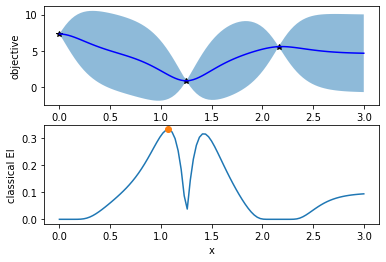

Best value found: 0.06479959773304039
Iteration 1, measuring at x=0.8795241713523865


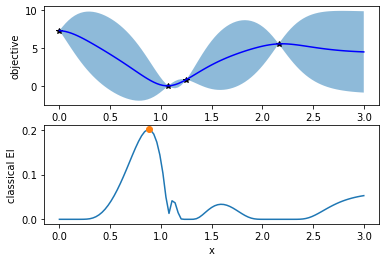

Best value found: 0.06479959773304039
Iteration 2, measuring at x=3.0


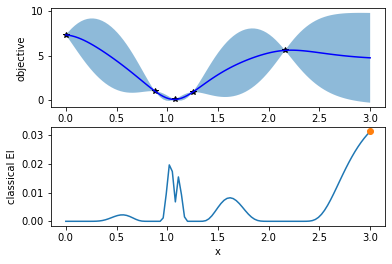

Best value found: 0.06479959773304039
Iteration 3, measuring at x=1.032623052597046


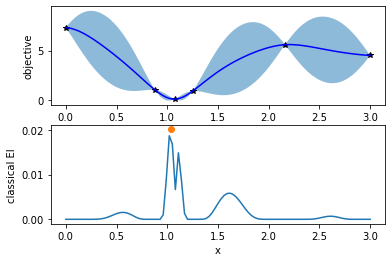

Best value found: 0.021251383415360425


In [26]:
np.random.seed(1)
n_initial_points = 3
n_BO_points = 4

# Generate initial data: several datapoints at random
# Each one of them will be uniform between 0 and 3
for i in range(n_initial_points):    
    new_x = lower + np.random.rand(1)*(upper-lower) # This is a vector containing 1 entry
    if i == 0:
        x,y,obj = add_data(new_x)
    else:
        x,y,obj = add_data(new_x,x,y,obj)
        
best = [obj.min()] # This will store the best value
print('Best value found: {}'.format(obj.min()))

for i in range(n_BO_points):
    # Fit the model
    noise = torch.ones_like(obj) * 0.0001
    model = FixedNoiseGP(x, obj, noise)
    fit_gpytorch_model(ExactMarginalLogLikelihood(model.likelihood, model))
    
    # Optimize EI, considering the problem to be a minimization problem
    EI = ExpectedImprovement(model=model, best_f=obj.min(), maximize=False)
    new_point, new_point_EI = optimize_acqf(
        acq_function=EI,
        bounds=torch.tensor([[lower], [upper]]),
        q=1,
        num_restarts=50,
        raw_samples=100,
    )
    
    # Plot the posterior and the EI
    f, (ax1,ax2) = plt.subplots(2, 1, figsize=(6, 4))
    test_x = torch.linspace(lower, upper, 101)
    
    # Plot the posterior
    plot_posterior_classic(ax1,model,test_x,x,obj,legend=False)
    
    # Plot EI
    acq = EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    ax2.plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'o')
    ax2.set_ylabel('classical EI')
    ax2.set_xlabel('x')
    
    print('Iteration {}, measuring at x={}'.format(i,new_point.item()) )
    plt.show()
    
    x,y,obj = add_data(new_point,x,y,obj)
    best.append(obj.min())
    print('Best value found: {}'.format(obj.min()))
    

(1e-06, 1)

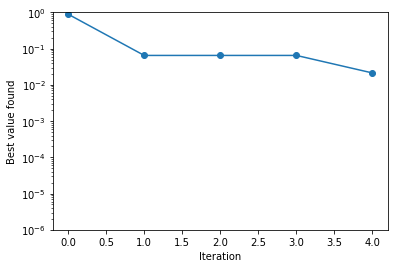

In [27]:
# Classical Bayesian optimization solves the problem pretty well
plt.plot(best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.yscale("log", base=10)
plt.ylim(1e-6,1)

# Step 5: Composite Bayesian Optimization

Best value found: 0.8904945968209156
Iteration 0, measuring at x=1.3326095342636108


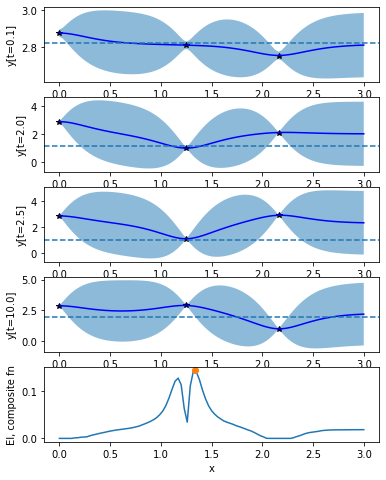

Best value found: 0.18237992485285295
Iteration 1, measuring at x=1.3610984086990356


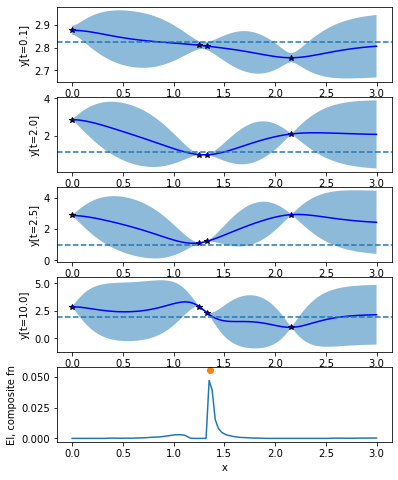

Best value found: 0.09919299853000538
Iteration 2, measuring at x=1.0348788499832153


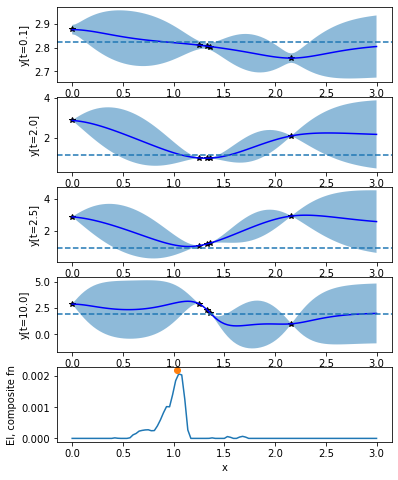

Best value found: 0.015219057389973985
Iteration 3, measuring at x=1.0481793880462646


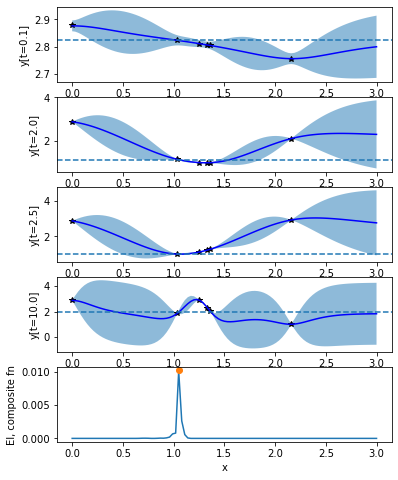

Best value found: 9.741253899598688e-05


In [30]:
np.random.seed(1)
n_initial_points = 3
n_BO_points = 4

# Generate initial data: several datapoints at random
# Each one of them will be uniform between 0 and 3
for i in range(n_initial_points):    
    new_x = lower + np.random.rand(1)*(upper-lower) # This is a vector containing 1 entry
    if i == 0:
        x,y,obj = add_data(new_x)
    else:
        x,y,obj = add_data(new_x,x,y,obj)
        
best = [obj.min()] # This will store the best value
print('Best value found: {}'.format(obj.min()))

for i in range(n_BO_points):

    # Fit the model
    noise = torch.ones_like(y) * 0.0001
    model = FixedNoiseGP(x, y, noise) # GP is on y, not the objective
    fit_gpytorch_model(ExactMarginalLogLikelihood(model.likelihood, model))
    
    # Optimize EI, where the objective is g(y), g is defined in the next line,
    # and y is the thing modeled by the multi-output FixedNoiseGP above. 
    # We set g to be the negative sum of squares so that we maximize instead of minimize.
    g = GenericMCObjective(objective=lambda _y: -(_y-torch.tensor(y_obs)).pow(2).sum(dim=-1))
    best_obj = g(y).max() # same as -obj.min()
    EI = qExpectedImprovement(model=model, best_f=best_obj, objective=g)
    new_point, new_point_EI = optimize_acqf(
        acq_function=EI,
        bounds=torch.tensor([[lower], [upper]]),
        q=1,
        num_restarts=50,
        raw_samples=100,
    )
        
    # Plot the posterior and the EI
    f, axs = plt.subplots(5, 1, figsize=(6, 8))
    test_x = torch.linspace(lower, upper, 101)
    
    # Plot the posterior
    for j in range(4):
        plot_posterior_composite(axs[j],model,test_x,x,y,j,legend=False)

    # Plot EI
    acq = EI.forward(test_x.unsqueeze(1).unsqueeze(1))
    axs[4].plot(test_x.numpy(), acq.detach().numpy(), '-', new_point.numpy(), new_point_EI.numpy(),'o')
    axs[4].set_xlabel('x')
    axs[4].set_ylabel('EI, composite fn')
    
    print('Iteration {}, measuring at x={}'.format(i,new_point.item()) )
    plt.show()
    
    x,y,obj = add_data(new_point,x,y,obj)
    best.append(obj.min())
    print('Best value found: {}'.format(obj.min()))
    

(1e-06, 1)

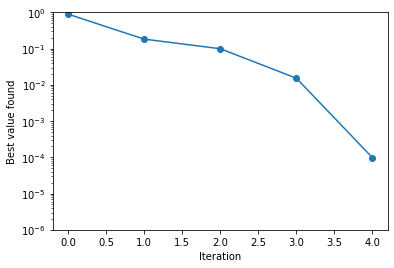

In [32]:
# Bayesian optimization of composite functions solves the problem much much faster
plt.plot(best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.yscale("log", base=10)
plt.ylim(1e-6,1)

# Exercises

Try exercise 1, which is the shortest of these exercises. Exercise 2 and 3 will take more time than we have available, and are provided if you'd like to dig deeper later on.

# Exercise 1: Inverse problems with regularization (easier)

Recall that the notebook above estimates a parameter by minimizing the sum of squared differences between observations and the simulation model's predictions, which we can write in the form:

$$\min_x \sum_{t} (y(x,t) - y_{\mathrm{obs}}(t))^2$$

Often when we solve inverse problems we add a penalty term to the objective that penalizes more complex models. Copy the notebook and modify it to solve the problem 

$$\min_x \sum_{t} (y(x,t) - y_{\mathrm{obs}}(t))^2 + \alpha x^2$$.

Solve the problem with $\alpha=1$.


This can be intepreted as finding the maximum a posteriori estimate in a Bayesian simulation calibration problem, where $\sum_{t} (y(x,t) - y_{\mathrm{obs}}(t))^2$ is the negative log of the likelihood of our observations (this occurs if we have normally distributed noise in our observations), and where the penalty term is the negative log prior density of the parameter $x$.

# Exercise 2: Bayesian optimization with input corruption (harder)

Copy this notebook and modify it in to solve the following problem.

We will choose a time point t. Then an adversary is going to choose among t, t+1, and t-1.
The adversary chooses so that the height of the pendulum at his chosen time is as small as possible. We want to choose t so that this adversarily chosen height is as large as possible.
When you simulate the pendulum, set the parameter x to the value x_real. Search over a range of t from 0 to 10. 

This is an example of Bayesian optimization that is robust to corruption of the input. Being robust to input corruption is important in many engineering design problems. For example, when we build a computer chip, the etched silicon is not going to be exactly the same as what we intended because of imperfections in the manufacturing process. We want the computer chip to still work despite these imperfections.

Play around with different numbers of samples in the initial stage of random sampling and different numbers of evaluations chosen by Bayesian optimization. You should see that standard Bayesian optimization has difficulty because the objective function has many sharp points where the derivative jumps, making the function hard to model, while Bayesian optimization of composite functions works well.

# Exercise 3: Multi-dimensional inverse problems (harder)

Notice that pendulum had 3 constants in addition to the one parameter we estimated from data.

Copy this notebook. Then modify it so that there are 4 parameters to estimate: the 1 original parameter and these 3 constants. Then use classical Bayesian optimization and Bayesian optimization of composite fuctions to estimate these parameters by minimizing the sum of squared errors.